## Setup Instructions

Before starting, ensure you have the necessary libraries installed. You can install them via pip. 
For SAM2, you might need specific repositories or models, so ensure you have access to the model weights and dependencies.

In [1]:
# pip install fiftyone torch torchvision
# highly recommend creating a virtual enviroment before installing

In [2]:
# Import necessary libraries
import torch
import torchvision
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F

import os, sys
import cv2
import matplotlib.pyplot as plt
from zipfile import ZipFile

import numpy as np
import PIL

## Fetch your Data 

In [3]:
dataset = foz.load_zoo_dataset( "open-images-v7", 
                               split="validation",
                               label_types =["segmentations"],
                               # label_field = "segmentations",
                               classes = ["Airplane", "Apple", "Balloon", "Wheel", "Coffee"],
                               max_samples =500,
                               dataset_name="segmask",
                               only_matching = True
                               )


Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'validation'
 100% |█████████████████| 500/500 [9.6s elapsed, 0s remaining, 47.9 samples/s]       
Dataset 'segmask' created


In [4]:
dataset

Name:        segmask
Media type:  image
Num samples: 500
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

<!-- 1. create list of 150 classes grouping them into 4 categories
2. for loop for each image - find which classes are present in each img, mask other classes - repeat 4 categories and make a folder structure for each -->

In [5]:
# # The directory containing the source images and annotations for training
# data_path = "/home/vanshika/voxel51/ADEChallengeData2016/images/training/"

# labels_path = "./ADEChallengeData2016/annotations/training/"

# # Import the dataset to fiftyone
# dataset = fo.Dataset.from_dir(
#     dataset_type=fo.types.ImageSegmentationDirectory,
#     data_path=data_path,
#     labels_path=labels_path
# )

# dataset.compute_metadata()

## View your Data

In [6]:
# dataset.head()

In [7]:
# dataset.get_field_schema() 

In [8]:
# dataset.select('66e4701ec3cdd1dba778f9d7')

In [9]:
# dataset.select_fields('field name')

In [10]:
# Get the first sample
first_sample = dataset.first()

# Get the last sample
last_sample = dataset.last()

# Get a random sample
random_sample = dataset.take(1)

In [11]:
# uniq = dataset.distinct('ground_truth')

In [12]:
results = fob.compute_similarity(dataset, brain_key="img_simt")

Computing embeddings...
 100% |█████████████████| 500/500 [2.5m elapsed, 0s remaining, 3.5 samples/s]      


In [13]:
results.find_unique(100)

Computing unique samples...
Generating index for 500 embeddings...
Index complete
threshold: 1.000000, kept: 6, target: 100
threshold: 0.500000, kept: 285, target: 100
threshold: 0.750000, kept: 44, target: 100
threshold: 0.625000, kept: 130, target: 100
threshold: 0.687500, kept: 75, target: 100
threshold: 0.656250, kept: 102, target: 100
threshold: 0.671875, kept: 88, target: 100
threshold: 0.664062, kept: 98, target: 100
threshold: 0.660156, kept: 100, target: 100
Uniqueness computation complete


In [14]:
unique_view = dataset.select(results.unique_ids)


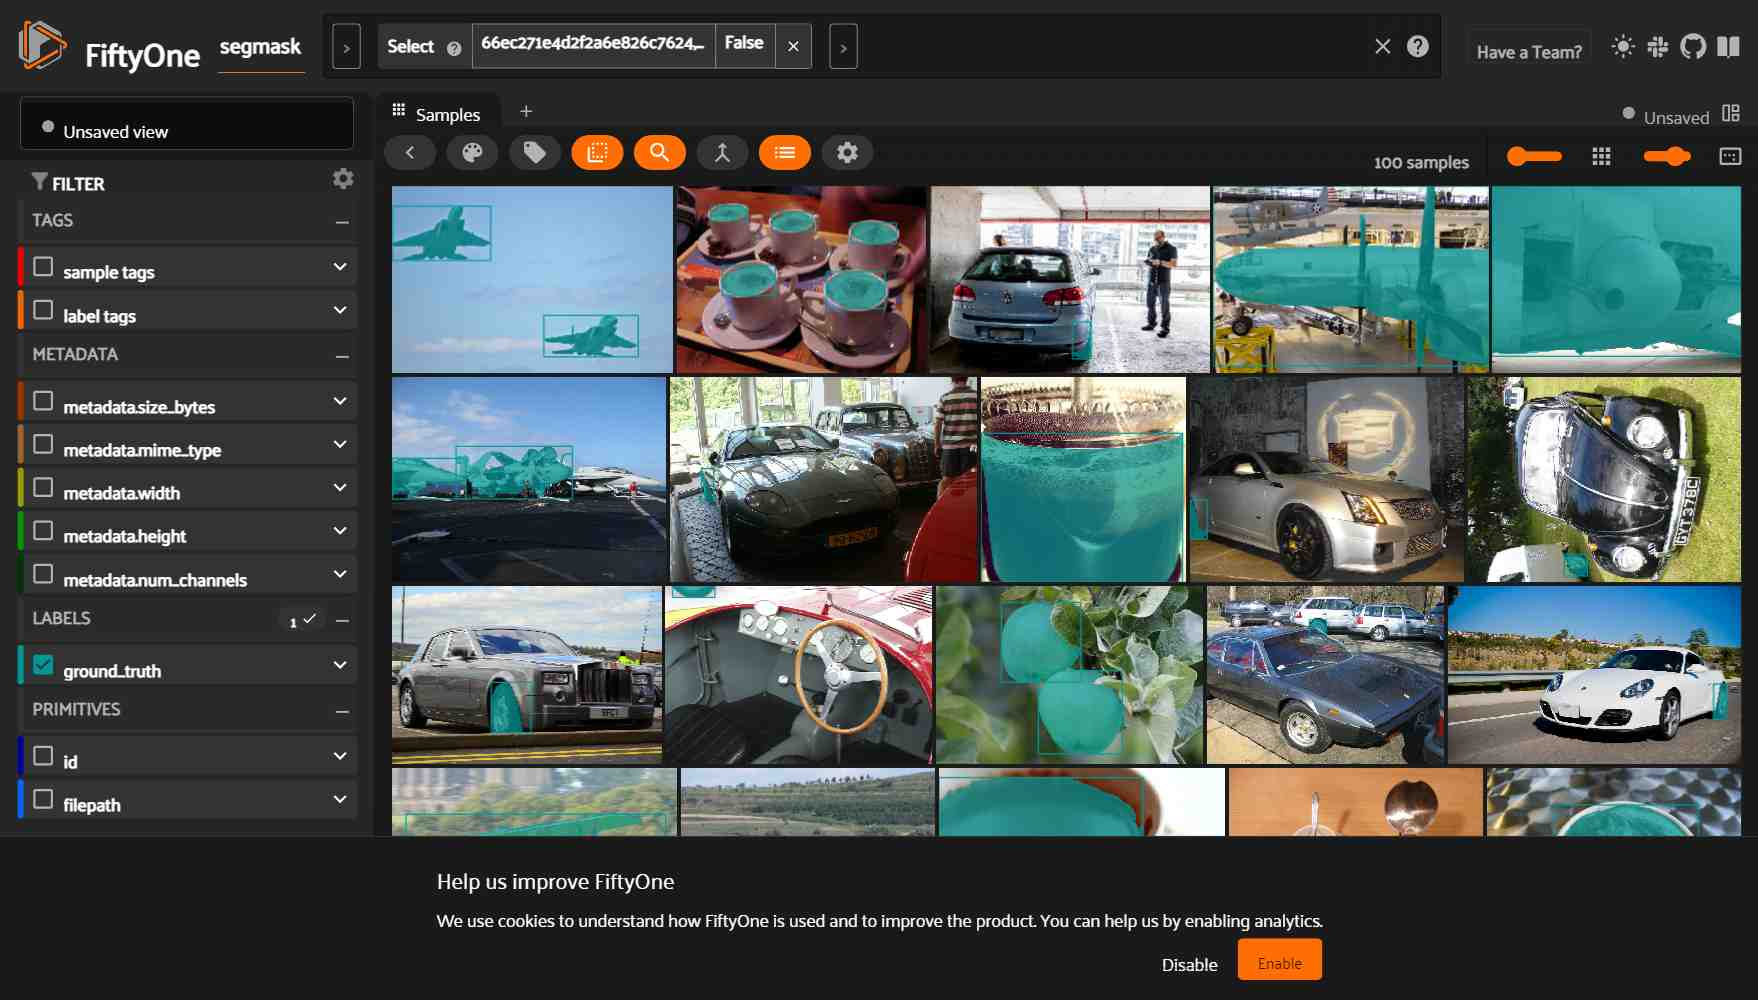

In [15]:
session = fo.launch_app(unique_view)

In [16]:
session.freeze()

## Load the Model and Evaluate

In [17]:
model = foz.load_zoo_model("segment-anything-2-hiera-base-plus-image-torch")

In [18]:
device="cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
print(f"using device: {device}")

using device: cpu


In [19]:
predictions_view = dataset.take(50)

In [23]:
# predictions_view.apply_model(
  #  model=model,
   # label_field="predictions",
    # confidence_thresh=0.7,
    # store_logits=False,
    # batch_size=16,
    # num_workers=1,
  #  skip_failures=True,
    # output_dir="path",
    # progress=True,

# )


In [42]:
results = predictions_view.evaluate_detections( "predictions", 
                                               gt_field="ground_truth", 
                                               eval_key="eval", 
                                               classes= ['Airplane' 'Apple' 'Balloon' 'Coffee' 'Wheel'],
                                               use_masks = True
)

# Convert to evaluation patches
eval_patches = predictions_view.to_evaluation_patches("eval")
print(eval_patches)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████████| 50/50 [4.2s elapsed, 0s remaining, 13.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 50/50 [4.2s elapsed, 0s remaining, 13.0 samples/s]      


Dataset:     segmask
Media type:  image
Num patches: 1509
Patch fields:
    id:           fiftyone.core.fields.ObjectIdField
    sample_id:    fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:        fiftyone.core.fields.BooleanField
    type:         fiftyone.core.fields.StringField
    iou:          fiftyone.core.fields.FloatField
View stages:
    1. Take(size=50, seed=None)
    2. ToEvaluationPatches(eval_key='eval', config=None)


In [43]:
print(eval_patches.count_values("type"))

{'fn': 53, 'fp': 1456}


In [45]:
1456/1509 * 100.0

96.48774022531478

In [44]:
session.view = eval_patches


In [33]:
session.freeze()

In [37]:
print(results.classes)

['Airplane' 'Apple' 'Balloon' 'Coffee' 'Wheel']


In [24]:
# results.plot_distances()